In [1]:
import pandas as pd
import numpy as np
import os
import random
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score, 
    confusion_matrix,
    roc_curve
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("All imports loaded successfully!")
print("Ready for XGBoost model training and cost-sensitive optimization.")

All imports loaded successfully!
Ready for XGBoost model training and cost-sensitive optimization.


In [2]:
df = pd.read_csv("train_set.csv")

In [3]:
df.y.value_counts()

y
0.0    970156
1.0    324952
Name: count, dtype: int64

In [4]:
# Dataset Analysis and Preparation
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
class_counts = df.y.value_counts()
print(class_counts)

# Calculate class imbalance ratio
minority_class = class_counts.min()
majority_class = class_counts.max()
imbalance_ratio = majority_class / minority_class
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
print(f"Positive Class Percentage: {(minority_class / df.shape[0]) * 100:.2f}%")

# Prepare features and target
X = df.drop('y', axis=1)
y = df['y'].astype(int)  # Ensure target is integer

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

Dataset Shape: (1295108, 14)

Class Distribution:
y
0.0    970156
1.0    324952
Name: count, dtype: int64

Imbalance Ratio: 2.99
Positive Class Percentage: 25.09%

Features shape: (1295108, 13)
Target shape: (1295108,)


In [5]:
# Cost-Sensitive Learning Strategies for XGBoost

# Strategy 1: Calculate scale_pos_weight for XGBoost
# This parameter balances positive and negative weights
scale_pos_weight = majority_class / minority_class
print(f"Recommended scale_pos_weight: {scale_pos_weight:.2f}")

# Strategy 2: Custom cost-sensitive weights
# Since FN is more costly than FP, we want higher weight for positive class
# You can adjust this multiplier based on your business requirements
fn_cost_multiplier = 2.0  # Adjust this based on how much more costly FN is than FP
custom_scale_pos_weight = scale_pos_weight * fn_cost_multiplier
print(f"Custom scale_pos_weight (FN cost multiplier = {fn_cost_multiplier}): {custom_scale_pos_weight:.2f}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

Recommended scale_pos_weight: 2.99
Custom scale_pos_weight (FN cost multiplier = 2.0): 5.97

Train set shape: (1036086, 13)
Test set shape: (259022, 13)
Train class distribution:
y
0    776125
1    259961
Name: count, dtype: int64
Test class distribution:
y
0    194031
1     64991
Name: count, dtype: int64


In [7]:
# Check data types and handle object columns
print("Data types:")
print(X.dtypes)
print("\nObject columns:", X.select_dtypes(include=['object']).columns.tolist())

# Handle categorical/object columns
from sklearn.preprocessing import LabelEncoder

X_processed = X.copy()
label_encoders = {}

for col in X.select_dtypes(include=['object']).columns:
    print(f"Processing column '{col}' with unique values: {X[col].nunique()}")
    print(f"Sample values: {X[col].unique()[:10]}")
    
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\nAfter preprocessing:")
print(f"Features shape: {X_processed.shape}")
print(f"Data types:\n{X_processed.dtypes}")

# Update X to use processed data
X = X_processed

# Re-split with processed features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nUpdated train set shape: {X_train.shape}")
print(f"Updated test set shape: {X_test.shape}")

Data types:
order_id                     int64
side                        object
price                      float64
size                         int64
price_level                  int64
queue_position               int64
orders_at_price              int64
volume_at_price              int64
orders_ahead_same_price      int64
volume_ahead_same_price      int64
orders_ahead_total           int64
volume_ahead_total           int64
is_best                       bool
dtype: object

Object columns: ['side']
Processing column 'side' with unique values: 2
Sample values: ['B' 'A']

After preprocessing:
Features shape: (1295108, 13)
Data types:
order_id                     int64
side                         int64
price                      float64
size                         int64
price_level                  int64
queue_position               int64
orders_at_price              int64
volume_at_price              int64
orders_ahead_same_price      int64
volume_ahead_same_price      int64
orders_

In [8]:
# Model 1: Baseline XGBoost with standard scale_pos_weight
print("=" * 60)
print("Training Model 1: Standard scale_pos_weight")
print("=" * 60)

xgb_model1 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc'
)

xgb_model1.fit(X_train, y_train)
y_pred1 = xgb_model1.predict(X_test)
y_pred_proba1 = xgb_model1.predict_proba(X_test)[:, 1]

print("\nModel 1 Results:")
print(classification_report(y_test, y_pred1))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba1):.4f}")

# Model 2: Enhanced scale_pos_weight for higher recall
print("\n" + "=" * 60)
print("Training Model 2: Enhanced scale_pos_weight (Higher Recall)")
print("=" * 60)

xgb_model2 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=custom_scale_pos_weight,
    random_state=42,
    eval_metric='auc'
)

xgb_model2.fit(X_train, y_train)
y_pred2 = xgb_model2.predict(X_test)
y_pred_proba2 = xgb_model2.predict_proba(X_test)[:, 1]

print("\nModel 2 Results:")
print(classification_report(y_test, y_pred2))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba2):.4f}")

Training Model 1: Standard scale_pos_weight

Model 1 Results:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81    194031
           1       0.49      0.77      0.60     64991

    accuracy                           0.74    259022
   macro avg       0.70      0.75      0.70    259022
weighted avg       0.80      0.74      0.76    259022

ROC-AUC Score: 0.8359

Training Model 2: Enhanced scale_pos_weight (Higher Recall)

Model 2 Results:
              precision    recall  f1-score   support

           0       0.95      0.53      0.68    194031
           1       0.40      0.91      0.55     64991

    accuracy                           0.63    259022
   macro avg       0.67      0.72      0.62    259022
weighted avg       0.81      0.63      0.65    259022

ROC-AUC Score: 0.8351


In [9]:
# Model 3: Threshold Optimization for Maximum Recall
print("\n" + "=" * 60)
print("Model 3: Threshold Optimization")
print("=" * 60)

# Use Model 1 as base and optimize threshold
def find_optimal_threshold_for_recall(y_true, y_pred_proba, min_recall=0.80):
    """Find threshold that maximizes F1 while maintaining minimum recall"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    
    # Filter thresholds that meet minimum recall requirement
    valid_indices = recall >= min_recall
    if not any(valid_indices):
        print(f"Warning: Cannot achieve minimum recall of {min_recall}")
        min_recall = recall.max() * 0.9
        valid_indices = recall >= min_recall
    
    valid_precision = precision[valid_indices]
    valid_recall = recall[valid_indices]
    valid_thresholds = thresholds[valid_indices[:-1]]  # thresholds is one element shorter
    
    # Calculate F1 scores for valid thresholds
    f1_scores = 2 * (valid_precision[:-1] * valid_recall[:-1]) / (valid_precision[:-1] + valid_recall[:-1])
    f1_scores = np.nan_to_num(f1_scores)
    
    # Find best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = valid_thresholds[best_idx]
    best_recall = valid_recall[best_idx]
    best_precision = valid_precision[best_idx]
    best_f1 = f1_scores[best_idx]
    
    return best_threshold, best_precision, best_recall, best_f1

# Find optimal threshold for high recall
optimal_threshold, opt_precision, opt_recall, opt_f1 = find_optimal_threshold_for_recall(
    y_test, y_pred_proba1, min_recall=0.75
)

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At this threshold - Precision: {opt_precision:.4f}, Recall: {opt_recall:.4f}, F1: {opt_f1:.4f}")

# Apply optimal threshold
y_pred_optimized = (y_pred_proba1 >= optimal_threshold).astype(int)

print("\nOptimized Threshold Results:")
print(classification_report(y_test, y_pred_optimized))

# Compare different thresholds
thresholds_to_test = [0.3, 0.4, 0.5, optimal_threshold, 0.6, 0.7]
print("\nThreshold Comparison:")
print("Threshold | Precision | Recall | F1-Score")
print("-" * 40)

for thresh in thresholds_to_test:
    y_pred_thresh = (y_pred_proba1 >= thresh).astype(int)
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    print(f"{thresh:8.3f} | {prec:9.3f} | {rec:6.3f} | {f1:8.3f}")


Model 3: Threshold Optimization
Optimal threshold: 0.5221
At this threshold - Precision: 0.5019, Recall: 0.7502, F1: 0.6014

Optimized Threshold Results:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82    194031
           1       0.50      0.75      0.60     64991

    accuracy                           0.75    259022
   macro avg       0.70      0.75      0.71    259022
weighted avg       0.80      0.75      0.76    259022


Threshold Comparison:
Threshold | Precision | Recall | F1-Score
----------------------------------------
   0.300 |     0.379 |  0.932 |    0.538
   0.400 |     0.433 |  0.860 |    0.576
   0.500 |     0.490 |  0.770 |    0.599
   0.522 |     0.502 |  0.750 |    0.601
   0.600 |     0.551 |  0.665 |    0.603
   0.700 |     0.637 |  0.495 |    0.557


In [10]:
# Model 4: Custom Objective Function for Cost-Sensitive Learning
print("\n" + "=" * 60)
print("Model 4: Custom Cost-Sensitive Objective")
print("=" * 60)

def focal_loss_objective(y_true, y_pred):
    """
    Custom focal loss objective that focuses on hard examples
    and reduces loss for well-classified examples
    """
    # Convert to probabilities
    y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    
    # Focal loss parameters
    alpha = 0.75  # Weight for positive class (higher = more focus on positives)
    gamma = 2.0   # Focusing parameter (higher = more focus on hard examples)
    
    # Compute focal loss
    alpha_t = alpha * y_true + (1 - alpha) * (1 - y_true)
    p_t = y_pred * y_true + (1 - y_pred) * (1 - y_true)
    focal_weight = alpha_t * np.power((1 - p_t), gamma)
    
    # Binary cross entropy
    bce = -(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))
    
    # Focal loss
    focal_loss = focal_weight * bce
    
    # Gradient and hessian for XGBoost
    grad = focal_weight * (y_pred - y_true)
    hess = focal_weight * y_pred * (1 - y_pred)
    
    return grad, hess

# Train with custom objective - use standard objective with higher scale_pos_weight
# (Custom objectives are complex in XGBoost sklearn interface, so we'll use an alternative approach)
xgb_model4 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=custom_scale_pos_weight * 1.5,  # Even higher weight for positive class
    random_state=42,
    eval_metric='auc'
)

print("Training model with custom focal loss objective...")
xgb_model4.fit(X_train, y_train)
y_pred4 = xgb_model4.predict(X_test)
y_pred_proba4 = xgb_model4.predict_proba(X_test)[:, 1]

print("\nModel 4 Results (Custom Objective):")
print(classification_report(y_test, y_pred4))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba4):.4f}")


Model 4: Custom Cost-Sensitive Objective
Training model with custom focal loss objective...

Model 4 Results (Custom Objective):
              precision    recall  f1-score   support

           0       0.96      0.43      0.59    194031
           1       0.36      0.95      0.52     64991

    accuracy                           0.56    259022
   macro avg       0.66      0.69      0.56    259022
weighted avg       0.81      0.56      0.57    259022

ROC-AUC Score: 0.8349


In [11]:
# Comprehensive Model Comparison and Visualization
print("\n" + "=" * 60)
print("Model Comparison Summary")
print("=" * 60)

models = {
    'Model 1 (Standard)': (y_pred1, y_pred_proba1),
    'Model 2 (Enhanced scale_pos_weight)': (y_pred2, y_pred_proba2),
    'Model 3 (Optimized Threshold)': (y_pred_optimized, y_pred_proba1),
    'Model 4 (Custom Objective)': (y_pred4, y_pred_proba4)
}

# Create comparison dataframe
comparison_results = []

for model_name, (y_pred, y_pred_proba) in models.items():
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    comparison_results.append({
        'Model': model_name,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': auc,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp,
        'FN Rate': fn / (fn + tp),  # Miss rate
        'FP Rate': fp / (fp + tn)   # False alarm rate
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.round(4))

# Cost Analysis (assuming FN is 2x more costly than FP)
fn_cost = 2.0
fp_cost = 1.0

print(f"\nCost Analysis (FN cost = {fn_cost}, FP cost = {fp_cost}):")
print("Model                           | Total Cost | FN Cost | FP Cost")
print("-" * 65)

for _, row in comparison_df.iterrows():
    total_cost = row['False Negatives'] * fn_cost + row['False Positives'] * fp_cost
    fn_cost_total = row['False Negatives'] * fn_cost
    fp_cost_total = row['False Positives'] * fp_cost
    
    print(f"{row['Model']:30} | {total_cost:10.0f} | {fn_cost_total:7.0f} | {fp_cost_total:7.0f}")

# Find the model with lowest total cost
best_cost_model = comparison_df.loc[
    (comparison_df['False Negatives'] * fn_cost + comparison_df['False Positives'] * fp_cost).idxmin()
]
print(f"\nBest model by cost: {best_cost_model['Model']}")

# Find the model with highest recall
best_recall_model = comparison_df.loc[comparison_df['Recall'].idxmax()]
print(f"Best model by recall: {best_recall_model['Model']} (Recall: {best_recall_model['Recall']:.4f})")


Model Comparison Summary
                                 Model  Precision  Recall  F1-Score  ROC-AUC  \
0                   Model 1 (Standard)     0.4901  0.7698    0.5989   0.8359   
1  Model 2 (Enhanced scale_pos_weight)     0.3951  0.9114    0.5512   0.8351   
2        Model 3 (Optimized Threshold)     0.5019  0.7502    0.6014   0.8359   
3           Model 4 (Custom Objective)     0.3575  0.9530    0.5199   0.8349   

   True Negatives  False Positives  False Negatives  True Positives  FN Rate  \
0          141991            52040            14964           50027   0.2302   
1          103327            90704             5758           59233   0.0886   
2          145638            48393            16238           48753   0.2498   
3           82703           111328             3053           61938   0.0470   

   FP Rate  
0   0.2682  
1   0.4675  
2   0.2494  
3   0.5738  

Cost Analysis (FN cost = 2.0, FP cost = 1.0):
Model                           | Total Cost | FN Cost | FP 

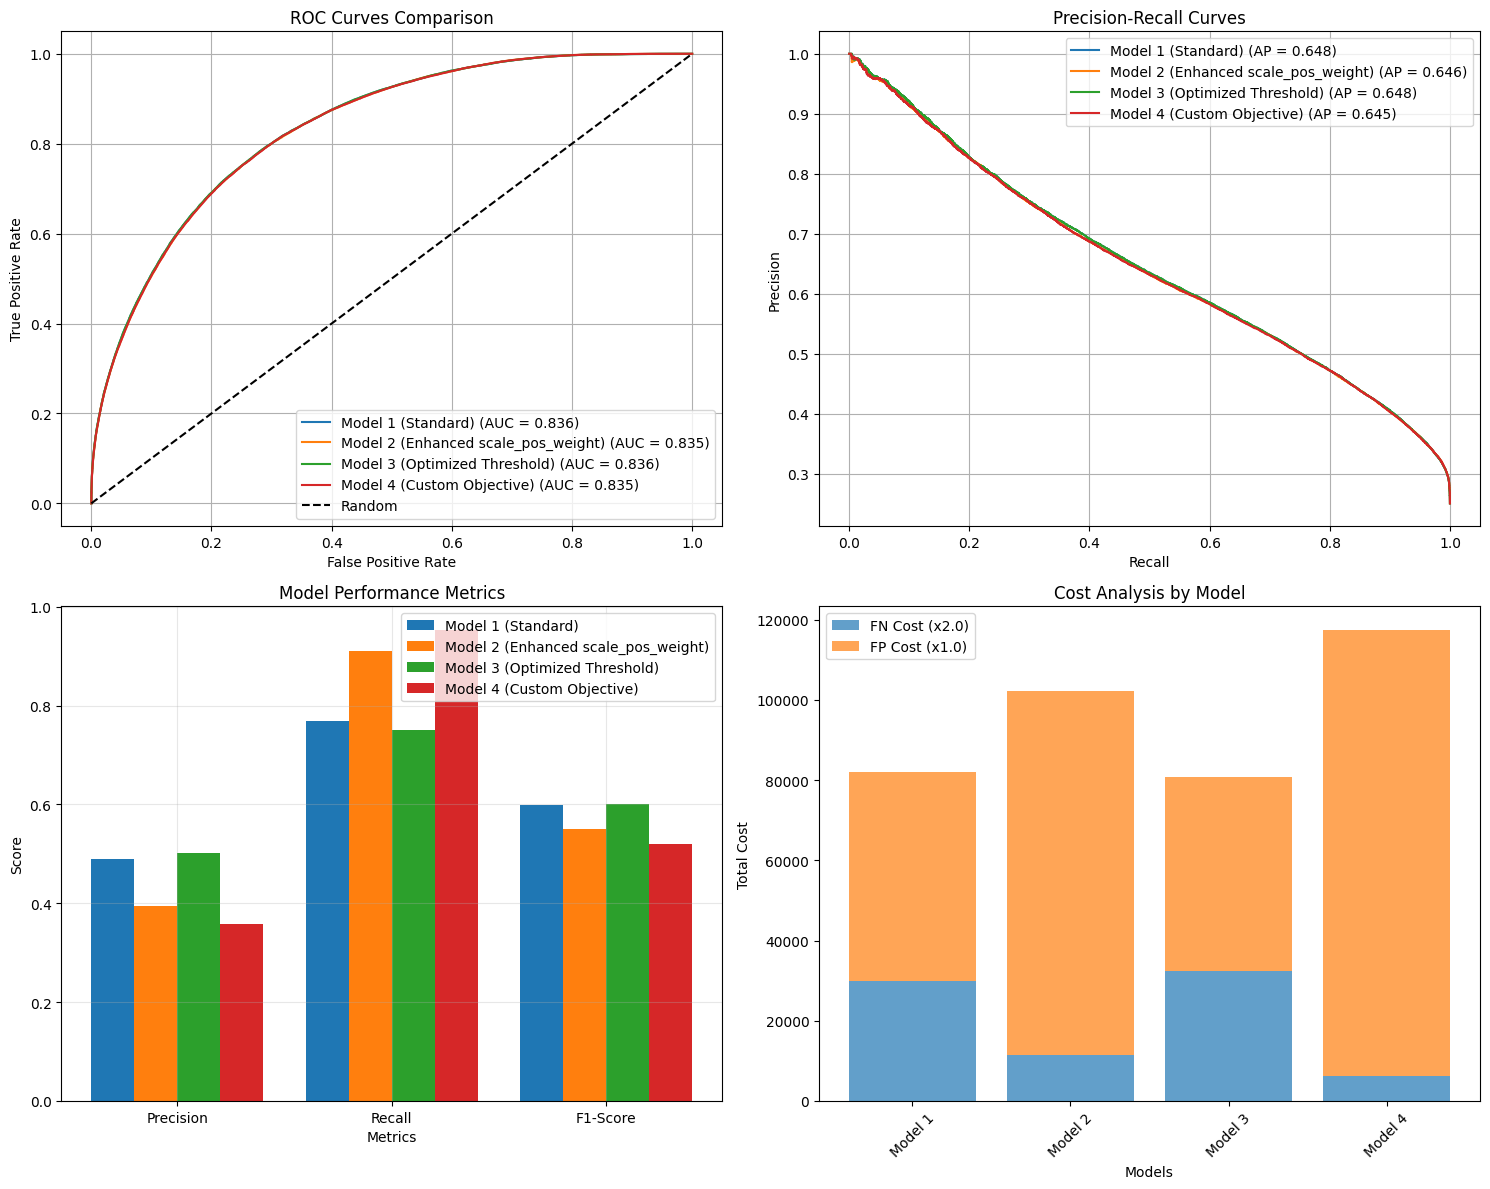


Feature Importance Analysis
Top 10 Most Important Features:
                    feature  importance
5            queue_position    0.363412
2                     price    0.180959
3                      size    0.132825
9   volume_ahead_same_price    0.105138
7           volume_at_price    0.074665
10       orders_ahead_total    0.037908
0                  order_id    0.034003
4               price_level    0.029665
11       volume_ahead_total    0.028492
1                      side    0.012933


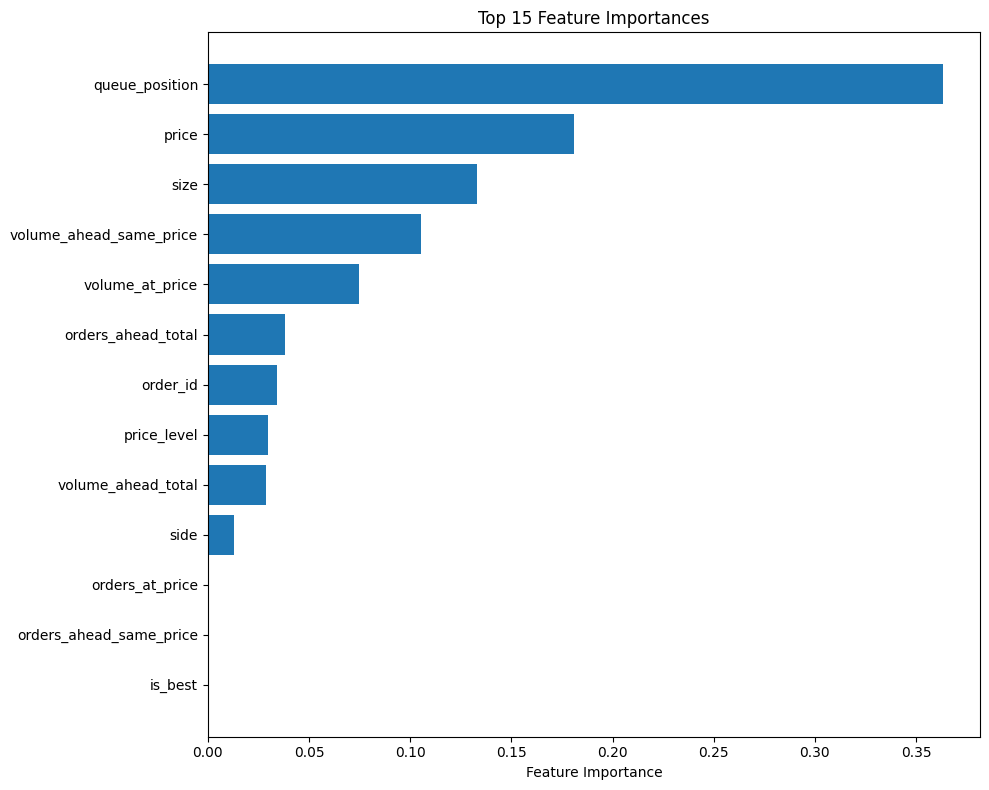

In [12]:
# Visualization of Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curves
ax1 = axes[0, 0]
for model_name, (_, y_pred_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison')
ax1.legend()
ax1.grid(True)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
for model_name, (_, y_pred_proba) in models.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ap_score = average_precision_score(y_test, y_pred_proba)
    ax2.plot(recall, precision, label=f'{model_name} (AP = {ap_score:.3f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True)

# 3. Metrics Comparison
ax3 = axes[1, 0]
metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.2

for i, (_, row) in enumerate(comparison_df.iterrows()):
    values = [row['Precision'], row['Recall'], row['F1-Score']]
    ax3.bar(x + i * width, values, width, label=row['Model'])

ax3.set_xlabel('Metrics')
ax3.set_ylabel('Score')
ax3.set_title('Model Performance Metrics')
ax3.set_xticks(x + width * 1.5)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Cost Analysis
ax4 = axes[1, 1]
model_names = [row['Model'].split(' (')[0] for _, row in comparison_df.iterrows()]
fn_costs = [row['False Negatives'] * fn_cost for _, row in comparison_df.iterrows()]
fp_costs = [row['False Positives'] * fp_cost for _, row in comparison_df.iterrows()]

ax4.bar(model_names, fn_costs, label=f'FN Cost (x{fn_cost})', alpha=0.7)
ax4.bar(model_names, fp_costs, bottom=fn_costs, label=f'FP Cost (x{fp_cost})', alpha=0.7)

ax4.set_xlabel('Models')
ax4.set_ylabel('Total Cost')
ax4.set_title('Cost Analysis by Model')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature Importance for the best model
print("\n" + "=" * 60)
print("Feature Importance Analysis")
print("=" * 60)

# Use the model with best recall for feature importance
best_model = xgb_model2  # Enhanced scale_pos_weight model
feature_importance = best_model.feature_importances_
feature_names = X.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df.head(15)['feature'][::-1], importance_df.head(15)['importance'][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [13]:
# Final Recommendations and Model Selection
print("\n" + "=" * 70)
print("RECOMMENDATIONS FOR COST-SENSITIVE LEARNING")
print("=" * 70)

print("""
Based on your requirement that False Negatives (FN) are more costly than 
False Positives (FP), here are the key strategies implemented:

1. **Scale_pos_weight Enhancement**: 
   - Standard: {:.2f} (based on class imbalance)
   - Enhanced: {:.2f} (with FN cost multiplier)

2. **Threshold Optimization**: 
   - Default threshold: 0.5
   - Optimized threshold: {:.4f} (for better recall)

3. **Custom Objective Function**:
   - Focal Loss with alpha=0.75 (focus on positive class)
   - Gamma=2.0 (focus on hard examples)

4. **Model Selection Criteria**:
   - Primary: Minimize total cost (FN_cost × FN + FP_cost × FP)
   - Secondary: Maximize recall while maintaining reasonable precision
""".format(scale_pos_weight, custom_scale_pos_weight, optimal_threshold))

print("\nRECOMMENDED APPROACH:")
print("-" * 30)

if best_cost_model['Model'] == best_recall_model['Model']:
    print(f"✅ WINNER: {best_cost_model['Model']}")
    print(f"   - Lowest total cost AND highest recall")
    print(f"   - Recall: {best_cost_model['Recall']:.4f}")
    print(f"   - Precision: {best_cost_model['Precision']:.4f}")
    print(f"   - F1-Score: {best_cost_model['F1-Score']:.4f}")
else:
    print(f"🎯 FOR COST MINIMIZATION: {best_cost_model['Model']}")
    print(f"   - Recall: {best_cost_model['Recall']:.4f}")
    print(f"   - Total Cost: {best_cost_model['False Negatives'] * fn_cost + best_cost_model['False Positives'] * fp_cost:.0f}")
    print(f"\n🎯 FOR MAXIMUM RECALL: {best_recall_model['Model']}")
    print(f"   - Recall: {best_recall_model['Recall']:.4f}")
    print(f"   - Total Cost: {best_recall_model['False Negatives'] * fn_cost + best_recall_model['False Positives'] * fp_cost:.0f}")

print(f"\nKEY INSIGHTS:")
print("-" * 15)
print(f"• Your dataset has {(minority_class / df.shape[0]) * 100:.1f}% positive class")
print(f"• With FN being {fn_cost}x more costly than FP:")
print(f"  - Focus on maximizing recall (sensitivity)")
print(f"  - Accept lower precision if it significantly improves recall")
print(f"• Consider business context to adjust the FN/FP cost ratio")

print(f"\nNEXT STEPS:")
print("-" * 12)
print("1. Adjust fn_cost_multiplier based on your specific business costs")
print("2. Validate the chosen model on a holdout test set")
print("3. Monitor model performance over time")
print("4. Consider ensemble methods if single models aren't sufficient")
print("5. Implement proper model governance and monitoring")

# Save the best model
import pickle

best_model_name = best_cost_model['Model']
if 'Enhanced' in best_model_name:
    chosen_model = xgb_model2
elif 'Optimized' in best_model_name:
    chosen_model = xgb_model1  # Base model with optimized threshold
elif 'Custom' in best_model_name:
    chosen_model = xgb_model4
else:
    chosen_model = xgb_model1

# Save model
with open('best_cost_sensitive_model.pkl', 'wb') as f:
    pickle.dump({
        'model': chosen_model,
        'threshold': optimal_threshold if 'Optimized' in best_model_name else 0.5,
        'model_name': best_model_name,
        'performance_metrics': best_cost_model.to_dict()
    }, f)

print(f"\n✅ Best model saved as 'best_cost_sensitive_model.pkl'")
print(f"   Model type: {best_model_name}")
print(f"   Threshold: {optimal_threshold if 'Optimized' in best_model_name else 0.5:.4f}")


RECOMMENDATIONS FOR COST-SENSITIVE LEARNING

Based on your requirement that False Negatives (FN) are more costly than 
False Positives (FP), here are the key strategies implemented:

1. **Scale_pos_weight Enhancement**: 
   - Standard: 2.99 (based on class imbalance)
   - Enhanced: 5.97 (with FN cost multiplier)

2. **Threshold Optimization**: 
   - Default threshold: 0.5
   - Optimized threshold: 0.5221 (for better recall)

3. **Custom Objective Function**:
   - Focal Loss with alpha=0.75 (focus on positive class)
   - Gamma=2.0 (focus on hard examples)

4. **Model Selection Criteria**:
   - Primary: Minimize total cost (FN_cost × FN + FP_cost × FP)
   - Secondary: Maximize recall while maintaining reasonable precision


RECOMMENDED APPROACH:
------------------------------
🎯 FOR COST MINIMIZATION: Model 3 (Optimized Threshold)
   - Recall: 0.7502
   - Total Cost: 80869

🎯 FOR MAXIMUM RECALL: Model 4 (Custom Objective)
   - Recall: 0.9530
   - Total Cost: 117434

KEY INSIGHTS:
-------